<a href="https://colab.research.google.com/github/nagu2k15/Azure-Devops/blob/master/jsonembedtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

pip install sentence-transformers faiss-cpu datasets

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
from datasets import load_dataset
from sklearn.metrics import ndcg_score
import random
from datasets import Dataset
import json
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
queries = load_dataset(path="milistu/amazon-esci-data", name="queries", split=["test"])[0]
products = load_dataset(path="milistu/amazon-esci-data", name="products", split=["test"])[0]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

queries/train-00000-of-00001.parquet:   0%|          | 0.00/47.9M [00:00<?, ?B/s]

queries/test-00000-of-00001.parquet:   0%|          | 0.00/15.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1983272 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/638016 [00:00<?, ? examples/s]

products/train-00000-of-00004.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

products/train-00001-of-00004.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

products/train-00002-of-00004.parquet:   0%|          | 0.00/203M [00:00<?, ?B/s]

products/train-00003-of-00004.parquet:   0%|          | 0.00/218M [00:00<?, ?B/s]

products/test-00000-of-00002.parquet:   0%|          | 0.00/147M [00:00<?, ?B/s]

products/test-00001-of-00002.parquet:   0%|          | 0.00/139M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1371823 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/443101 [00:00<?, ? examples/s]

In [ ]:
from numpy._core.fromnumeric import prod
random.seed(42)
queries_sample = queries.shuffle(seed = 42).select(range(5000))
prod_map = {p["product_id"]: p for p in products}
reference_ids = set(q["product_id"] for q in queries_sample)
products_subset = [prod_map[pid] for pid in reference_ids if pid in prod_map]
print(len(products_subset))

3809


In [ ]:
def flatten_product(product):
  return (
    f"Product {product['product_title']} from brand {product['product_brand']}"
    f" and product id {product['product_id']}"
    f" and description {product['product_description']}"
)

In [ ]:
json_products = []
flat_products = []
for product in products_subset:
  json_products.append(
      json.dumps({
          "product_id": product["product_id"],
          "title": product["product_title"],
          "description": product["product_description"],
          "brand": product["product_brand"],
          "color": product["product_color"]
      })
  )
  flat_products.append(flatten_product(product))
print(json_products[2345])

{"product_id": "B07ZD3D7DL", "title": "Agenda Semanal 2020. Charuca Navy. Grande", "description": null, "brand": "CHARUCA", "color": null}


In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
json_embeds = model.encode(json_products, batch_size=64, convert_to_numpy=True, show_progress_bar=True)
flat_embeds = model.encode(flat_products, batch_size=64, convert_to_numpy=True, show_progress_bar=True)

Batches:   0%|          | 0/60 [00:00<?, ?it/s]

Batches:   0%|          | 0/60 [00:00<?, ?it/s]

In [ ]:
faiss.normalize_L2(json_embeds)
faiss.normalize_L2(flat_embeds)

In [ ]:
D = 384 # model dimenstionality
index_json = faiss.IndexFlatIP(D)
index_flatten = faiss.IndexFlatIP(D)

In [ ]:
index_json.add(json_embeds)
index_flatten.add(flat_embeds)

In [ ]:
query_texts = [q["query"] for q in queries_sample]
q_embed = model.encode(query_texts, batch_size=64, convert_to_numpy=True, show_progress_bar=True)

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
faiss.normalize_L2(q_embed)

In [ ]:
binary_map = {"E": 1, "S": 1, "C": 0, "I": 0}

In [ ]:
def precision_k(pred_ids, relevant_ids, k):
  return len(set(pred_ids[:k]) &  relevant_ids)/ k

def recall_k(pred_ids, relevant_ids, k):
  if len(relevant_ids) == 0:
    return 0.0
  return len(set(pred_ids[:k]) &  relevant_ids) / len(relevant_ids)

def mrr(pred_ids, relevant_ids):
    for rank, pid in enumerate(pred_ids, start=1):
        if pid in relevant_ids:
            return 1.0 / rank
    return 0.0



In [ ]:
# map index to product_id
idx_to_pid = [prod["product_id"] for prod in products_subset]


In [ ]:
k = 10
D_json, I_json = index_json.search(q_embed, k)
D_flat, I_flat = index_flatten.search(q_embed, k)

In [ ]:
query_to_relevant = query_to_relevant = queries_sample.to_pandas().groupby("query_id").apply(lambda x: set(x[x["esci_label"].isin(["E", "S"])]["product_id"])).to_dict()

/tmp/ipython-input-1287911846.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  query_to_relevant = query_to_relevant = queries_sample.to_pandas().groupby("query_id").apply(lambda x: set(x[x["esci_label"].isin(["E", "S"])]["product_id"])).to_dict()


In [ ]:
prec_json, recall_json, mrr_json = [], [], []
q_ids = [q["query_id"] for q in queries_sample]
for i, qid in enumerate(q_ids):
  pred_ids = [idx_to_pid[idx] for idx in I_json[i]]
  relevant_ids = query_to_relevant[qid]
  prec_json.append(precision_k(pred_ids, relevant_ids, k))
  recall_json.append(recall_k(pred_ids, relevant_ids, k))
  mrr_json.append(mrr(pred_ids, relevant_ids))

In [ ]:
prec_flat, recall_flat, mrr_flat = [], [], []
q_ids = [q["query_id"] for q in queries_sample]
for i, qid in enumerate(q_ids):
  pred_ids = [idx_to_pid[idx] for idx in I_flat[i]]
  relevant_ids = query_to_relevant[qid]
  prec_flat.append(precision_k(pred_ids, relevant_ids, k))
  recall_flat.append(recall_k(pred_ids, relevant_ids, k))
  mrr_flat.append(mrr(pred_ids, relevant_ids))

         Metric    JSON  Flattened
0  Precision@10  0.0419    0.05018
1     Recall@10  0.3658    0.43570
2           MRR  0.2715    0.34542


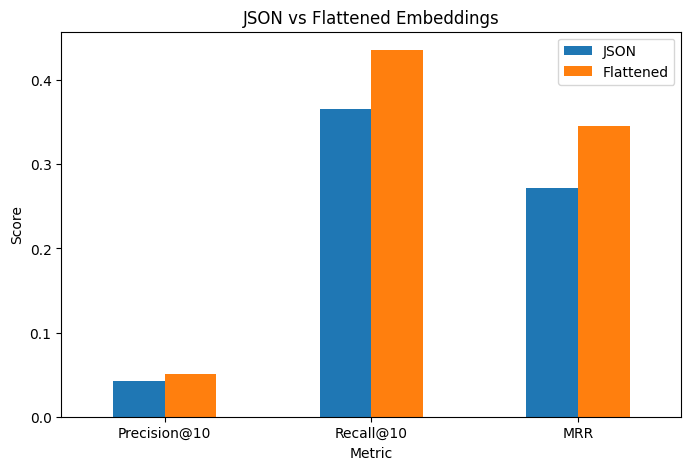

In [ ]:
results = pd.DataFrame({
    "Metric": ["Precision@10", "Recall@10", "MRR"],
    "JSON": [np.mean(prec_json), np.mean(recall_json), np.mean(mrr_json)],
    "Flattened": [np.mean(prec_flat), np.mean(recall_flat), np.mean(mrr_flat)],
})
print(results)

results_plot = results.set_index("Metric")
results_plot.plot(kind = "bar", figsize = (8,5), rot = 0, title="JSON vs Flattened Embeddings")
plt.ylabel("Score")
plt.show()

         Metric    JSON  Flattened
0  Precision@10  0.0419    0.05018
1     Recall@10  0.3658    0.43570
2           MRR  0.2715    0.34542
0    19.761337
1    19.108803
2    27.226344
dtype: float64


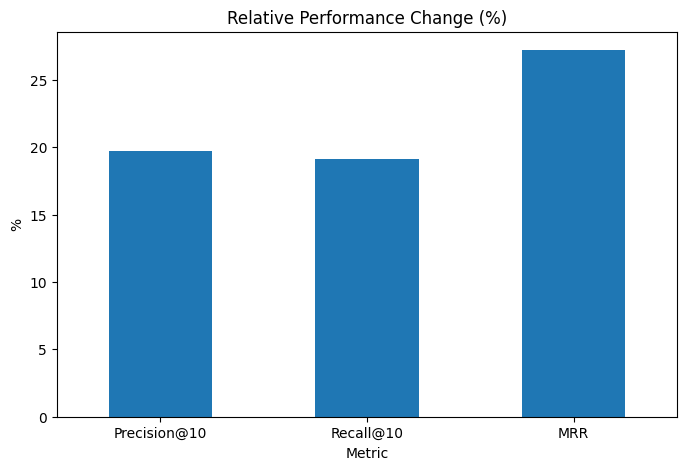

In [ ]:

change_results = pd.DataFrame({
    "Metric": ["Precision@10", "Recall@10", "MRR"],
    "JSON": [np.mean(prec_json), np.mean(recall_json), np.mean(mrr_json)],
    "Flattened": [np.mean(prec_flat), np.mean(recall_flat), np.mean(mrr_flat)],
})
results["Change"] = ((results["Flattened"] - results["JSON"]) / results["JSON"]) * 100
print(change_results)
print(((results["Flattened"] - results["JSON"]) / results["JSON"]) * 100)

results_plot = results.set_index("Metric")
results_plot["Change"].plot(kind = "bar", figsize = (8,5), rot = 0, title="Relative Performance Change (%)")
plt.ylabel("%")
plt.show()